## DataLoader

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import sklearn


# Step 1: Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (np.ndarray): A numpy array of shape (num_samples, input_dim).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return torch.tensor(sample, dtype=torch.float32)

# Step 2: Generate Example Data
def generate_dummy_data(num_samples=1000, input_dim=10):
    """Generates dummy data for testing the dataloader."""
    return sklearn.datasets.make_classification(
        n_samples=num_samples, n_features=input_dim, 
        n_informative=input_dim, n_redundant=0, random_state=42)

# Step 3: Transformations (Optional)
def normalize_data(sample):
    """Normalize the sample to have values between 0 and 1."""
    return sample / np.max(sample)

# Step 4: Initialize Dataset and DataLoader
data = generate_dummy_data(num_samples=1000, input_dim=10)
dataset = CustomDataset(data, transform=normalize_data)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



## Encoder

In [2]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, context_dim):
        super(Encoder, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [context_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:  # No activation in the final layer
                layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


## Decoder

In [3]:
class Decoder(nn.Module):
    def __init__(self, context_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()
        layers = []
        dims = [context_dim] + hidden_dims + [output_dim]
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:  # No activation in the final layer
                layers.append(nn.ReLU())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


## Train

In [5]:
# Verify if has cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
encoder = Encoder(input_dim=10, hidden_dims=[64, 32], context_dim=4)
decoder = Decoder(context_dim=4, hidden_dims=[32, 64], output_dim=10)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

# Example Training Loop
for epoch in range(100):
    for batch in dataloader:
        x = batch  # Assuming x is your input data
        context = encoder(x)
        output = decoder(context)
        loss = criterion(output, x)  # Reconstruction loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.1960677206516266
Epoch 2, Loss: 0.08682373911142349
Epoch 3, Loss: 0.10540065914392471
Epoch 4, Loss: 0.08731197565793991
Epoch 5, Loss: 0.0836188793182373
Epoch 6, Loss: 0.07901400327682495
Epoch 7, Loss: 0.06600934267044067
Epoch 8, Loss: 0.08013717830181122
Epoch 9, Loss: 0.06892639398574829
Epoch 10, Loss: 0.0649399533867836
Epoch 11, Loss: 0.06518590450286865
Epoch 12, Loss: 0.04918515309691429
Epoch 13, Loss: 0.05811886861920357
Epoch 14, Loss: 0.06619428098201752
Epoch 15, Loss: 0.044385459274053574
Epoch 16, Loss: 0.06273706257343292
Epoch 17, Loss: 0.0665559396147728
Epoch 18, Loss: 0.0548190101981163
Epoch 19, Loss: 0.07604411244392395
Epoch 20, Loss: 0.06194514036178589
Epoch 21, Loss: 0.07573673129081726
Epoch 22, Loss: 0.07726768404245377
Epoch 23, Loss: 0.07143890857696533
Epoch 24, Loss: 0.0666922926902771
Epoch 25, Loss: 0.04757101088762283
Epoch 26, Loss: 0.058903902769088745
Epoch 27, Loss: 0.060009945183992386
Epoch 28, Loss: 0.05961461737751961
Epoc

# Visualize Context Vector

/tmp/ipykernel_30355/3339605382.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_context[:, 0], reduced_context[:, 1], alpha=0.7, s=20, cmap='viridis')


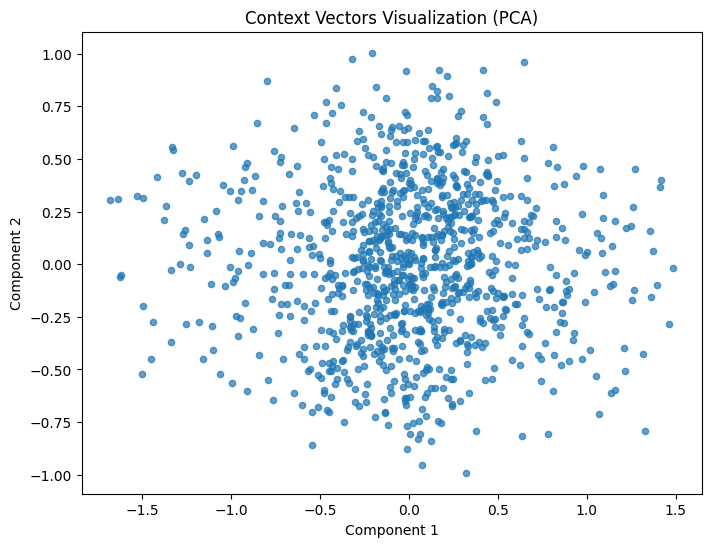

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_context_vectors(encoder, dataloader):
    """Extracts context vectors from the encoder for the entire dataset."""
    context_vectors = []
    encoder.eval()
    with torch.no_grad():
        for batch in dataloader:
            context = encoder(batch)
            context_vectors.append(context.numpy())
    return np.vstack(context_vectors)


def visualize_context_vectors(context_vectors, method="pca"):
    """Visualizes context vectors using PCA or t-SNE."""
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_context = reducer.fit_transform(context_vectors)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_context[:, 0], reduced_context[:, 1], alpha=0.7, s=20, cmap='viridis')
    plt.title(f"Context Vectors Visualization ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

context_vectors = extract_context_vectors(encoder, dataloader)
visualize_context_vectors(context_vectors, method="pca")

In [8]:
context_vectors.shape

(1000, 4)